<a href="https://colab.research.google.com/github/pranathadoddy/down-syndrome/blob/main/ResnetDownSyndrome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [43]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

from torchvision import datasets
from torchvision import transforms

from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from PIL import Image

In [44]:
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
df = pd.read_excel('/content/drive/MyDrive/downsyndrome/labeling.xlsx')
df['dosya'] = df['dosya'].str.replace('/content/fotolar/fotolar/', '')

df['eyetoeye'] = pd.to_numeric(df['eyetoeye'], errors='coerce')
df['eyetomouth'] = pd.to_numeric(df['eyetomouth'], errors='coerce')

# Drop rows with non-numeric values in 'eyetoeye' or 'eyetomouth' columns
df = df.dropna(subset=['eyetoeye', 'eyetomouth'], how='any')
df

,dosya,eyetoeye,eyetomouth,class
0,down_1.jpg,3.333333,131.666667,1
1,down_10.jpg,5.000000,170.000000,1
2,down_100.jpg,3.333333,113.333333,1
3,down_1000.jpg,1.666667,106.666667,1
4,down_1001.jpg,1.666667,111.666667,1
...,...,...,...,...
1556,healty_238.jpg,20.000000,118.333333,0
1557,healty_239.jpg,13.333333,110.000000,0
1558,healty_24.jpg,0.000000,105.000000,0
1559,healty_242.jpg,11.666667,110.000000,0


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


Text(0.5, 1.0, '(300, 300, 3)')

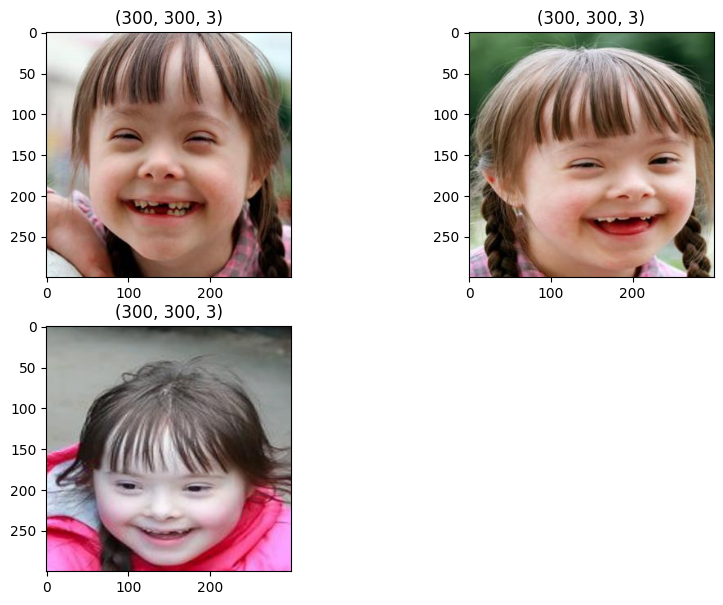

In [47]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 2, 1)

img1 = Image.open('/content/drive/MyDrive/downsyndrome/downSyndorme/downSyndrome/down_1.jpg')
print(np.asarray(img1, dtype=np.uint8).shape)
plt.imshow(img1);
plt.title(np.asarray(img1, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 2)

img2 = Image.open('/content/drive/MyDrive/downsyndrome/downSyndorme/downSyndrome/down_10.jpg')
print(np.asarray(img2, dtype=np.uint8).shape)
plt.imshow(img2);
plt.title(np.asarray(img2, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 3)

img3 = Image.open('/content/drive/MyDrive/downsyndrome/downSyndorme/downSyndrome/down_11.jpg')
print(np.asarray(img3, dtype=np.uint8).shape)
plt.imshow(img3);
plt.title(np.asarray(img3, dtype=np.uint8).shape)

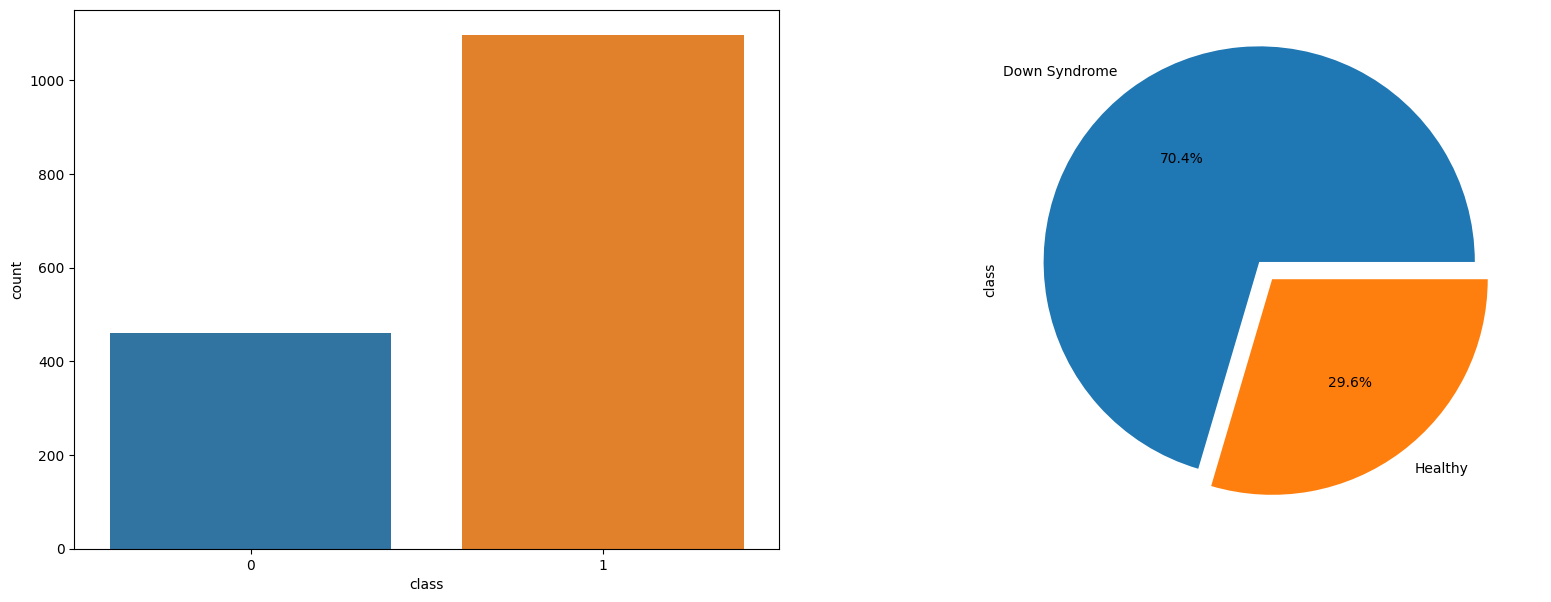

In [48]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

sns.countplot(x=df["class"], ax=ax[0])
df["class"].value_counts().plot.pie(explode=[0.1, 0],autopct="%1.1f%%",labels=["Down Syndrome", "Healthy"], ax=ax[1])

plt.show()

In [49]:
category_count = df['class'].value_counts()
print(category_count)

1    1096
0     460
Name: class, dtype: int64


In [50]:
higher_category = list(category_count.index)[0]
higher_category

1

In [51]:
# np.random.seed(42)
# indices = df[df['class'] == higher_category].index
# sample_size = category_count[1] - category_count[0]

# drop_sample = np.random.choice(indices, sample_size, replace = False)
# df_balance = df.drop(drop_sample, axis = 'index')

# df_balance.set_index('dosya', inplace=True)
# df_balance

In [52]:
# fig, ax = plt.subplots(1,2, figsize=(20,7))

# sns.countplot(x=df_balance["class"], ax=ax[0])
# df_balance["class"].value_counts().plot.pie(explode=[0.1, 0],autopct="%1.1f%%",labels=["Down Syndrome", "Healthy"], ax=ax[1])

# plt.show()

In [53]:
#df_balance.shape

In [54]:
 df.set_index('dosya', inplace=True)

# Train Test Split

In [55]:
train, test_df = train_test_split(df, test_size = 0.3)
validate, test = train_test_split(test_df, test_size=0.33)

In [56]:
train.shape, validate.shape, test.shape

((1089, 3), (312, 3), (155, 3))

In [57]:
train.to_csv('downsyndrome_train.csv')
validate.to_csv('downsyndrome_valid.csv')
test.to_csv('downsyndrome_test.csv')

# Data Loader

In [58]:
class ImageDownSyndromeDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['class'].values
        self.transform = transform

    def __getitem__(self, index):
        directory = 'healty/healty'
        if self.y[index] == 1:
           directory = 'downSyndorme/downSyndrome'

        img = Image.open(os.path.join(self.img_dir+directory,
                                      self.img_names[index]))
        img = img.convert('RGBA')

        if self.transform is not None:
            img = self.transform(img)

        tabularDf = df.reset_index()
        tabularDf = tabularDf[["eyetoeye", "eyetomouth"]].astype('float64')
        tabular = torch.FloatTensor(tabularDf.values)
        label = self.y[index]

        return img, tabular, label

    def __len__(self):
        return self.y.shape[0]

In [59]:
# def collate_fn(batch):
#     num_channels = [item[0].shape[0] for item in batch]
#     majority_channels = max(set(num_channels), key=num_channels.count)

#     # Filter out tensors with different number of channels
#     filtered_batch = [(data, target) for (data, target) in batch if data.shape[0] == majority_channels]

#     if len(filtered_batch) == 0:
#         raise ValueError("All tensors have different numbers of channels.")

#     # Stack data tensors along a new batch dimension
#     data = torch.stack([item[0] for item in filtered_batch], dim=0)

#     # Combine targets into a list
#     targets = torch.tensor([item[1] for item in filtered_batch])

#     return data, targets



custom_transform = transforms.Compose([transforms.CenterCrop((170, 170)),
                                       transforms.Resize((128, 128)),
                                       transforms.Grayscale(),
                                       transforms.ToTensor()])


train_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_train.csv',
                              img_dir='/content/drive/MyDrive/downsyndrome/',
                                         transform=custom_transform)

valid_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_valid.csv',
                              img_dir='/content/drive/MyDrive/downsyndrome/',
                              transform=custom_transform)

test_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_test.csv',
                             img_dir='/content/drive/MyDrive/downsyndrome/',
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [60]:
len(train_loader)

5

# Train

In [61]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
#                                padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(planes * 4)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out




# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes, grayscale):
#         self.inplanes = 64
#         if grayscale:
#             in_dim = 1
#         else:
#             in_dim = 4
#         super(ResNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
#         self.fc = nn.Sequential(
#             nn.Linear(32768, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096)
#         )
#         self.fc_tabular = nn.Sequential(
#             nn.Linear(2, 8),
#             nn.ReLU(True),
#             nn.Linear(8, 16),
#             nn.ReLU(True),
#             nn.Linear(16, 32),
#             nn.ReLU(True),
#             nn.Linear(32, 64),
#             nn.ReLU(True),
#             nn.Linear(64, 128),
#             nn.ReLU(True),
#             nn.Linear(256, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 256),
#             nn.ReLU(True),
#             nn.Linear(256, 256),
#         )

#         self.f_connected1 = nn.Linear(2,20)
#         self.f_connected2 = nn.Linear(20,20)

#         self.fc_combine = nn.Sequential(
#             nn.Linear(4096 + 199168, 4096),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes),
#         )

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, (2. / n)**.5)
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x, tabular):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)

#         logits = self.fc(x)

#         tabular = tabular.to(torch.float32)
#         print(tabular.shape)
#         tabular_features = self.f_connected1(tabular)

#         tabular_features = self.fc_tabular(tabular)
#         tabular_features = tabular_features.view(tabular_features.size(0), -1)
#         print(logits.shape)
#         print(tabular_features.shape)
#         combined_features = torch.cat((logits, tabular_features), dim=1)

#         output = self.fc_combine(combined_features)
#         probas = F.softmax(output, dim=1)
#         #print(output)
#         return output, probas



# def resnet101(num_classes, grayscale):
#     """Constructs a ResNet-101 model."""
#     model = ResNet(block=Bottleneck,
#                    layers=[3, 4, 23, 3],
#                    num_classes=2,
#                    grayscale=grayscale)
#     return model

In [62]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNetUnder100(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 4
        super(ResNetUnder100, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048, 4096)
        self.fc_tabular = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(True),
            nn.Linear(8, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 256),
        )
        self.fc_combine = nn.Sequential(
            #nn.Linear(4096 + 99584, num_classes)
            #
            # nn.Linear(4096 + 199168, num_classes)
            nn.Linear(4096 + 398336, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, tabular):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        logits = self.fc(x)

        tabular = tabular.to(torch.float32)
        #print(tabular.shape)
        #tabular_features = self.f_connected1(tabular)

        tabular_features = self.fc_tabular(tabular)
        tabular_features = tabular_features.view(tabular_features.size(0), -1)
        #print(logits.shape)
        #print(tabular_features.shape)
        combined_features = torch.cat((logits, tabular_features), dim=1)

        output = self.fc_combine(combined_features)
        probas = F.softmax(output, dim=1)
        #print(probas)
        return output, probas

def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNetUnder100(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model

In [63]:
from torchsummary import summary

torch.manual_seed(1)

model = resnet34(num_classes=2, grayscale=True)

model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


In [64]:
torch.backends.cuda.max_split_size_mb = 256
torch.cuda.empty_cache()

In [67]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, tabular, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)
        tabular = tabular.to(DEVICE)

        logits, probas = model(features, tabular)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100



trainingEpoch_loss = []
validationEpoch_loss = []

trainingEpoch_accuracy = []
validationEpoch_accuracy = []

torch.backends.cuda.max_split_size_mb = 256
torch.cuda.empty_cache()

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, (features, tabular, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        tabular = tabular.to(DEVICE)

        logits, probas = model(features, tabular)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()

        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))

    # model.eval()
    # validationStep_loss = []
    # for batch_idx, (features, tabular, targets) in enumerate(valid_loader):

    #     features = features.to(DEVICE)
    #     targets = targets.to(DEVICE)
    #     tabular = tabular.to(DEVICE)

    #     logits, probas = model(features, tabular)
    #     cost = cost_fn(logits, targets)
    #     optimizer.zero_grad()

    #     cost.backward()

    #     optimizer.step()
    #     validationStep_loss.append(cost.item())
    # print("Validation Loss: {}".format(np.array(validationStep_loss).mean()))
    # validationEpoch_loss.append(np.array(validationStep_loss).mean())

    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, device=DEVICE)
        print('Epoch: {} | Train: {} | Valid: {}'.format(
              epoch+1,
              train_accuracy,
              valid_accuracy))
        trainingEpoch_accuracy.append(train_accuracy)
        validationEpoch_accuracy.append(valid_accuracy)

Epoch: 001/010 | Batch 0000/0005 | Cost: 0.5784
tensor(70.0643, device='cuda:0')
tensor(70.5128, device='cuda:0')
Epoch: 1 | Train: 70.06427764892578 | Valid: 70.5128173828125
Epoch: 002/010 | Batch 0000/0005 | Cost: 0.6197
tensor(70.0643, device='cuda:0')
tensor(70.5128, device='cuda:0')
Epoch: 2 | Train: 70.06427764892578 | Valid: 70.5128173828125
Epoch: 003/010 | Batch 0000/0005 | Cost: 0.5576
tensor(35.8127, device='cuda:0')
tensor(35.5769, device='cuda:0')
Epoch: 3 | Train: 35.81267166137695 | Valid: 35.57692337036133
Epoch: 004/010 | Batch 0000/0005 | Cost: 0.7426
tensor(70.0643, device='cuda:0')
tensor(70.5128, device='cuda:0')
Epoch: 4 | Train: 70.06427764892578 | Valid: 70.5128173828125
Epoch: 005/010 | Batch 0000/0005 | Cost: 0.6535
tensor(70.0643, device='cuda:0')
tensor(70.5128, device='cuda:0')
Epoch: 5 | Train: 70.06427764892578 | Valid: 70.5128173828125
Epoch: 006/010 | Batch 0000/0005 | Cost: 0.5687
tensor(70.0643, device='cuda:0')
tensor(70.5128, device='cuda:0')
Epoch

In [66]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

tensor(72.9032, device='cuda:0')
Test accuracy: 72.90%
